In [ ]:
# upgrade pip tooling first
# %pip install -q --upgrade pip setuptools wheel

# remove any conflicting wheels that may be half-installed
# %pip uninstall -y -q numpy scipy scikit-learn array-api-compat

# install a compatible trio for Python 3.12
# %pip install -q --no-cache-dir --force-reinstall \
#  "numpy==2.1.2" "scipy==1.14.1" "scikit-learn==1.5.2"


In [ ]:
# import os, time
# print("Restarting runtime to finalize installs…")
# time.sleep(1)
# os._exit(0)


# Imports + versions

In [ ]:
import os, re, unicodedata, inspect
import numpy as np
import pandas as pd

import numpy as _np, scipy as _scipy, sklearn as _sk
print("NumPy:", _np.__version__)
print("SciPy:", _scipy.__version__)
print("sklearn:", _sk.__version__)


NumPy: 2.0.2
SciPy: 1.16.3
sklearn: 1.6.1


# Load both CSVs (raw)

In [ ]:
SENTIMENT_CSV = "combined_sentiment_data.csv"
EMOTIONS_CSV  = "combined_emotion.csv"


read_opts = dict(
    dtype=str,
    na_values=["", " ", "NA", "NaN", "nan", None],
    keep_default_na=True,
    on_bad_lines="skip",
    encoding_errors="replace"
)

df_sent_raw = pd.read_csv(SENTIMENT_CSV, **read_opts)
df_emot_raw = pd.read_csv(EMOTIONS_CSV, **read_opts)

def guess_cols(df):
    candidates_text  = {"text","tweet","content","sentence","comment","body","review"}
    candidates_label = {"label","sentiment","target","polarity","emotion"}
    text_col  = next((c for c in df.columns if c.lower() in candidates_text),  df.columns[0])
    label_col = next((c for c in df.columns if c.lower() in candidates_label), df.columns[-1])
    return text_col, label_col

sent_text_col, sent_label_col = guess_cols(df_sent_raw)
emot_text_col, emot_label_col = guess_cols(df_emot_raw)

print("Sentiment shape:", df_sent_raw.shape, "| guessed:", sent_text_col, "/", sent_label_col)
print("Emotion   shape:", df_emot_raw.shape, "| guessed:", emot_text_col, "/", emot_label_col)


Sentiment shape: (3309, 2) | guessed: sentence / sentiment
Emotion   shape: (422746, 2) | guessed: sentence / emotion


# Clean + encode (for both datasets)

In [ ]:
from sklearn.preprocessing import LabelEncoder

def clean_and_encode(df_raw, text_col, label_col):
    df = df_raw.rename(columns={text_col: "text", label_col: "label"}).copy()
    df = df.dropna(subset=["text","label"])
    df["text"] = df["text"].astype(str).str.strip()
    df = df[df["text"].str.len() > 0]

    # dedupe to avoid leakage later
    df["_norm"] = (
        df["text"].str.lower()
        .str.replace(r"\s+", " ", regex=True)
        .str.strip()
    )
    df = df.drop_duplicates(subset=["_norm","label"]).drop(columns=["_norm"]).reset_index(drop=True)

    # label encode
    le = LabelEncoder()
    df["label_encoded"] = le.fit_transform(df["label"].astype(str))
    id2label = {i: lab for i, lab in enumerate(le.classes_)}
    label2id = {lab: i for i, lab in id2label.items()}
    return df, id2label, label2id, len(id2label)

df_sent, id2label_sent, label2id_sent, num_labels_sent = clean_and_encode(df_sent_raw, sent_text_col, sent_label_col)
df_emot, id2label_emot, label2id_emot, num_labels_emot = clean_and_encode(df_emot_raw, emot_text_col, emot_label_col)

print(f"[Sentiment] rows={len(df_sent)} classes={num_labels_sent}")
print(f"[Emotion]   rows={len(df_emot)} classes={num_labels_emot}")


[Sentiment] rows=3286 classes=2
[Emotion]   rows=416123 classes=6


# Build a combined multitask dataframe

In [ ]:
import pandas as pd
import numpy as np

IGNORE_INDEX = -100  # tells CE loss to ignore missing labels

# Rename encoded columns to task-specific names
sent_df = df_sent[["text", "label_encoded"]].rename(columns={"label_encoded": "label_sent"})
emot_df = df_emot[["text", "label_encoded"]].rename(columns={"label_encoded": "label_emot"})

# Tag rows and add masked columns
sent_df["label_emot"] = IGNORE_INDEX
emot_df["label_sent"] = IGNORE_INDEX

# Union of both datasets (rows from each carry one valid label and one masked)
mtl_df = pd.concat([sent_df, emot_df], ignore_index=True)

# (Optional) Shuffle for mixing tasks
mtl_df = mtl_df.sample(frac=1.0, random_state=42).reset_index(drop=True)

# Quick peek
print(mtl_df.head(3))
print("Counts:",
      "\n rows:", len(mtl_df),
      "\n sentiment-labeled:", (mtl_df["label_sent"] != IGNORE_INDEX).sum(),
      "\n emotion-labeled:  ", (mtl_df["label_emot"] != IGNORE_INDEX).sum())


                                                text  label_sent  label_emot
0            i still feel like the last tragic entry        -100           4
1  i know there have been a multitude of posts in...        -100           2
2  ive been feeling troubled and moody these days...        -100           4
Counts: 
 rows: 419409 
 sentiment-labeled: 3286 
 emotion-labeled:   416123


# Train/Val/Test split (stratify by “has which label”)

In [ ]:
from sklearn.model_selection import train_test_split

RNG = 42
has_sent = (mtl_df["label_sent"] != IGNORE_INDEX).astype(int)
has_emot = (mtl_df["label_emot"] != IGNORE_INDEX).astype(int)

# We stratify by which task label exists to keep task mix similar across splits
train_df, hold_df = train_test_split(
    mtl_df, test_size=0.20, random_state=RNG,
    stratify=has_sent + 2*has_emot  # four combos (0/1 per task)
)
val_df, test_df = train_test_split(
    hold_df, test_size=0.50, random_state=RNG,
    stratify=(hold_df["label_sent"] != IGNORE_INDEX).astype(int) + 2*(hold_df["label_emot"] != IGNORE_INDEX).astype(int)
)

print("Sizes → train/val/test:", len(train_df), len(val_df), len(test_df))
print("Train task mix:",
      (train_df["label_sent"] != IGNORE_INDEX).sum(),
      (train_df["label_emot"] != IGNORE_INDEX).sum())


Sizes → train/val/test: 335527 41941 41941
Train task mix: 2629 332898


# Tokenizer + HF Datasets (labels per task)

In [ ]:
from datasets import Dataset, Value
from transformers import AutoTokenizer

model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tok(batch):
    enc = tokenizer(batch["text"], truncation=True, padding="max_length", max_length=128)
    enc["labels_sent"] = batch["label_sent"]
    enc["labels_emot"] = batch["label_emot"]
    return enc

def to_ds(pdf):
    pdf = pdf.copy()
    pdf["label_sent"] = pdf["label_sent"].astype("int64")
    pdf["label_emot"] = pdf["label_emot"].astype("int64")
    ds = Dataset.from_pandas(pdf[["text","label_sent","label_emot"]], preserve_index=False)
    ds = ds.map(tok, batched=True, remove_columns=["text"])
    ds = ds.cast_column("labels_sent", Value("int64"))
    ds = ds.cast_column("labels_emot", Value("int64"))
    ds.set_format(type="torch",
                  columns=["input_ids","attention_mask","labels_sent","labels_emot"])
    return ds

train_ds = to_ds(train_df)
val_ds   = to_ds(val_df)
test_ds  = to_ds(test_df)

print("len(train_ds):", len(train_ds))
print("feature keys:", train_ds.features.keys())


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/335527 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/335527 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/335527 [00:00<?, ? examples/s]

Map:   0%|          | 0/41941 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/41941 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/41941 [00:00<?, ? examples/s]

Map:   0%|          | 0/41941 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/41941 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/41941 [00:00<?, ? examples/s]

len(train_ds): 335527
feature keys: dict_keys(['label_sent', 'label_emot', 'input_ids', 'attention_mask', 'labels_sent', 'labels_emot'])


# Multi-head model (shared DistilBERT + 2 classifiers)

## Baseline Model 1.  Multi-head model with TF-IDF + Logistic Regression

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt

# Prepare data
# Use already-cleaned DataFrames
sent_df = df_sent.copy()
emot_df = df_emot.copy()

X_sent, y_sent = sent_df["text"], sent_df["label_encoded"]
X_emot, y_emot = emot_df["text"], emot_df["label_encoded"]

# TF-IDF representation
tfidf = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1,2),
    stop_words="english",
    sublinear_tf=True
)
tfidf.fit(pd.concat([X_sent, X_emot], axis=0))  # shared vocab

X_sent_tfidf = tfidf.transform(X_sent)
X_emot_tfidf = tfidf.transform(X_emot)

# Train Logistic Regression classifiers
sent_clf = LogisticRegression(max_iter=1000, random_state=42)
emot_clf = LogisticRegression(max_iter=1000, random_state=42)

sent_clf.fit(X_sent_tfidf, y_sent)
emot_clf.fit(X_emot_tfidf, y_emot)



LogisticRegression(max_iter=1000, random_state=42)


--- Sentiment ---
Accuracy    : 0.8907
Precision   : 0.8915
Recall      : 0.8907
F1          : 0.8907
F1_micro    : 0.8907

--- Emotion ---
Accuracy    : 0.9233
Precision   : 0.9228
Recall      : 0.9233
F1          : 0.9229
F1_micro    : 0.9233


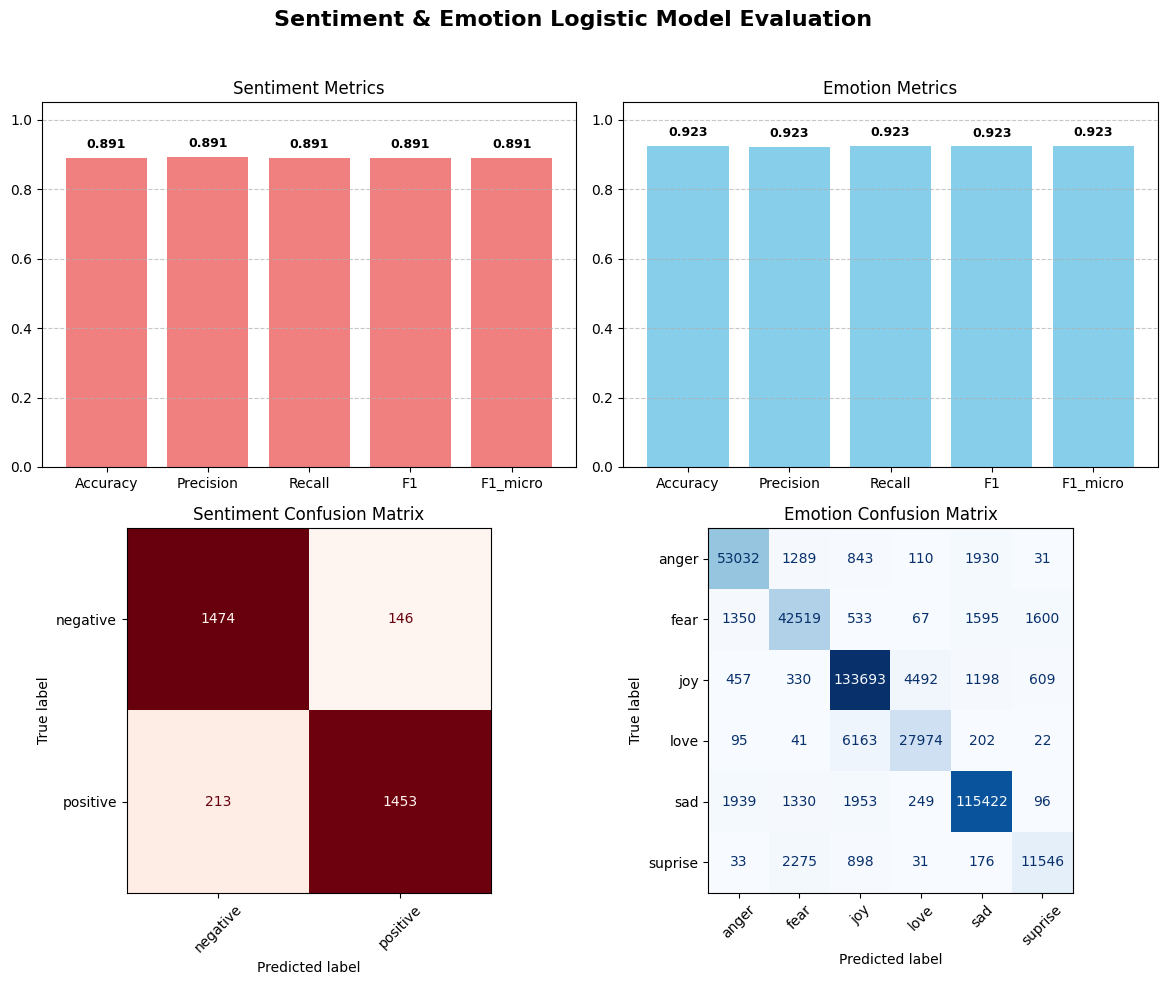

In [ ]:
def eval_two_models(sent_model, X_sent, y_sent, id2label_sent,
                    emot_model, X_emot, y_emot, id2label_emot):
    # Show 2 metric histograms and 2 confusion matrices in one figure.

    # helper: compute metrics + confusion matrix
    def compute_metrics(model, X, y):
        preds = model.predict(X)
        acc = accuracy_score(y, preds)
        prec, rec, f1, _ = precision_recall_fscore_support(y, preds, average="weighted", zero_division=0)
        f1_mi = f1_score(y, preds, average="micro", zero_division=0)
        cm = confusion_matrix(y, preds)
        return preds, cm, {"Accuracy": acc, "Precision": prec, "Recall": rec, "F1": f1, "F1_micro": f1_mi}

    # Compute for both tasks
    _, cm_sent, metrics_sent = compute_metrics(sent_model, X_sent, y_sent)
    _, cm_emot, metrics_emot = compute_metrics(emot_model, X_emot, y_emot)

    # Print numeric metrics
    print("\n--- Sentiment ---")
    for k, v in metrics_sent.items():
        print(f"{k:12s}: {v:.4f}")
    print("\n--- Emotion ---")
    for k, v in metrics_emot.items():
        print(f"{k:12s}: {v:.4f}")

    # Create 2×2 subplot grid
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    fig.suptitle("Sentiment & Emotion Logistic Model Evaluation", fontsize=16, fontweight="bold")

    # Sentiment Metrics Histogram
    bars1 = axes[0, 0].bar(metrics_sent.keys(), metrics_sent.values(), color="lightcoral")
    axes[0, 0].set_title("Sentiment Metrics")
    axes[0, 0].set_ylim(0, 1.05)
    axes[0, 0].grid(axis="y", linestyle="--", alpha=0.7)
    for bar in bars1:
        h = bar.get_height()
        axes[0, 0].text(bar.get_x() + bar.get_width()/2, h + 0.02, f"{h:.3f}",
                        ha="center", va="bottom", fontsize=9, fontweight="bold")

    # Emotion Metrics Histogram
    bars2 = axes[0, 1].bar(metrics_emot.keys(), metrics_emot.values(), color="skyblue")
    axes[0, 1].set_title("Emotion Metrics")
    axes[0, 1].set_ylim(0, 1.05)
    axes[0, 1].grid(axis="y", linestyle="--", alpha=0.7)
    for bar in bars2:
        h = bar.get_height()
        axes[0, 1].text(bar.get_x() + bar.get_width()/2, h + 0.02, f"{h:.3f}",
                        ha="center", va="bottom", fontsize=9, fontweight="bold")

    # Sentiment Confusion Matrix
    disp_sent = ConfusionMatrixDisplay(cm_sent,
        display_labels=[id2label_sent[i] for i in sorted(id2label_sent.keys())])
    disp_sent.plot(ax=axes[1, 0], cmap="Reds", colorbar=False)
    axes[1, 0].set_title("Sentiment Confusion Matrix")
    axes[1, 0].tick_params(axis='x', rotation=45)

    # Emotion Confusion Matrix
    disp_emot = ConfusionMatrixDisplay(cm_emot,
        display_labels=[id2label_emot[i] for i in sorted(id2label_emot.keys())])
    disp_emot.plot(ax=axes[1, 1], cmap="Blues", colorbar=False)
    axes[1, 1].set_title("Emotion Confusion Matrix")
    axes[1, 1].tick_params(axis='x', rotation=45)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# Run evaluation
eval_two_models(
    sent_clf, X_sent_tfidf, y_sent, id2label_sent,
    emot_clf, X_emot_tfidf, y_emot, id2label_emot
)

## Baseline Model 2.  Multi-head model with TF-IDF + SVM

In [ ]:
# SVM multi-task pipeline with hyperparameter tuning
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay
)

# Use the pre-split data
# IGNORE_INDEX = -100 (from your earlier setup)
train_sent = train_df[train_df["label_sent"] != -100]
val_sent   = val_df[val_df["label_sent"] != -100]
test_sent  = test_df[test_df["label_sent"] != -100]

train_emot = train_df[train_df["label_emot"] != -100]
val_emot   = val_df[val_df["label_emot"] != -100]
test_emot  = test_df[test_df["label_emot"] != -100]

# Build TF-IDF shared vocabulary on both tasks

tfidf = TfidfVectorizer(max_features=10000, ngram_range=(1,2),
                        stop_words="english", sublinear_tf=True)

tfidf.fit(pd.concat([train_sent["text"], train_emot["text"]], axis=0))

X_train_sent = tfidf.transform(train_sent["text"])
X_val_sent   = tfidf.transform(val_sent["text"])
X_test_sent  = tfidf.transform(test_sent["text"])
y_train_sent = train_sent["label_sent"]
y_val_sent   = val_sent["label_sent"]
y_test_sent  = test_sent["label_sent"]

X_train_emot = tfidf.transform(train_emot["text"])
X_val_emot   = tfidf.transform(val_emot["text"])
X_test_emot  = tfidf.transform(test_emot["text"])
y_train_emot = train_emot["label_emot"]
y_val_emot   = val_emot["label_emot"]
y_test_emot  = test_emot["label_emot"]


# Define SVM hyperparameter grid
param_grid = [
    {"kernel": ["linear"], "C": [0.1, 1, 10]},
    {"kernel": ["rbf"], "C": [0.1, 1, 10], "gamma": ["scale", 0.1, 0.01]},
    {"kernel": ["poly"], "C": [0.1, 1, 10], "degree": [2, 3], "gamma": ["scale"]}
]

def tune_svm(X, y, param_grid, name="task"):
    print(f"Tuning SVM for {name} ...")
    grid = GridSearchCV(
        SVC(), param_grid=param_grid, scoring="f1_weighted",
        cv=3, n_jobs=-1, verbose=0
    )
    grid.fit(X, y)
    print(f"Best {name}: {grid.best_params_}, F1_weighted={grid.best_score_:.4f}")
    return grid.best_estimator_


# Tune and train SVM for both tasks
sent_clf = tune_svm(X_train_sent, y_train_sent, param_grid, name="Sentiment")
emot_clf = tune_svm(X_train_emot, y_train_emot, param_grid, name="Emotion")

Tuning SVM for Sentiment ...
Best Sentiment: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}, F1_weighted=0.7763
Tuning SVM for Emotion ...


In [ ]:
# Evaluate and collect metrics
def evaluate(model, X_test, y_test):
    preds = model.predict(X_test)
    acc = accuracy_score(y_test, preds)
    prec = precision_score(y_test, preds, average="weighted", zero_division=0)
    rec = recall_score(y_test, preds, average="weighted", zero_division=0)
    f1_w = f1_score(y_test, preds, average="weighted", zero_division=0)
    f1_mi = f1_score(y_test, preds, average="micro", zero_division=0)
    cm = confusion_matrix(y_test, preds)
    metrics = {"Accuracy": acc, "Precision": prec, "Recall": rec, "F1_weighted": f1_w, "F1_micro": f1_mi}
    return metrics, cm

metrics_sent, cm_sent = evaluate(sent_clf, X_test_sent, y_test_sent)
metrics_emot, cm_emot = evaluate(emot_clf, X_test_emot, y_test_emot)

print("\n=== Sentiment metrics ===")
for k, v in metrics_sent.items():
    print(f"{k:12s}: {v:.4f}")
print("\n=== Emotion metrics ===")
for k, v in metrics_emot.items():
    print(f"{k:12s}: {v:.4f}")


# Plot two histograms + two confusion matrices in one figure

def plot_metrics_and_confusions(metrics_sent, cm_sent, id2label_sent,
                                metrics_emot, cm_emot, id2label_emot):
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle("TF-IDF + SVM Multi-Task Evaluation", fontsize=16, fontweight="bold")

    # (1) Sentiment metrics histogram
    ax = axes[0, 0]
    bars = ax.bar(metrics_sent.keys(), metrics_sent.values(), color="tab:orange")
    ax.set_title("Sentiment Metrics")
    ax.set_ylim(0, 1.05)
    for bar in bars:
        h = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, h + 0.02, f"{h:.3f}", ha="center", fontsize=9)
    ax.grid(axis="y", linestyle="--", alpha=0.6)

    # (2) Emotion metrics histogram
    ax = axes[0, 1]
    bars = ax.bar(metrics_emot.keys(), metrics_emot.values(), color="tab:blue")
    ax.set_title("Emotion Metrics")
    ax.set_ylim(0, 1.05)
    for bar in bars:
        h = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, h + 0.02, f"{h:.3f}", ha="center", fontsize=9)
    ax.grid(axis="y", linestyle="--", alpha=0.6)

    # (3) Sentiment confusion matrix
    ax = axes[1, 0]
    disp = ConfusionMatrixDisplay(cm_sent, display_labels=[id2label_sent[i] for i in sorted(id2label_sent.keys())])
    disp.plot(ax=ax, cmap="Oranges", colorbar=False)
    ax.set_title("Sentiment Confusion Matrix")
    ax.tick_params(axis="x", rotation=45)

    # (4) Emotion confusion matrix
    ax = axes[1, 1]
    disp = ConfusionMatrixDisplay(cm_emot, display_labels=[id2label_emot[i] for i in sorted(id2label_emot.keys())])
    disp.plot(ax=ax, cmap="Blues", colorbar=False)
    ax.set_title("Emotion Confusion Matrix")
    ax.tick_params(axis="x", rotation=45)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

plot_metrics_and_confusions(metrics_sent, cm_sent, id2label_sent, metrics_emot, cm_emot, id2label_emot)

# Trainer (we’ll compute metrics ourselves later)